In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

In [45]:
# --- Task 1: Load and Preprocess the HAR Data ---
PATH = "UCI_HAR_Dataset/"
X_train = pd.read_csv(PATH + "train/X_train.txt", sep=r"\s+", header=None)
y_train = pd.read_csv(PATH + "train/y_train.txt", sep=r"\s+", header=None, names=["Activity"])
X_test = pd.read_csv(PATH + "test/X_test.txt", sep=r"\s+", header=None)
y_test = pd.read_csv(PATH + "test/y_test.txt", sep=r"\s+", header=None, names=["Activity"])

In [46]:
# map activity IDs to names
activity_map = {1: "WALKING", 2: "WALKING_UPSTAIRS", 3: "WALKING_DOWNSTAIRS", 
                4: "SITTING", 5: "STANDING", 6: "LAYING"}
y_train["Activity"] = y_train["Activity"].map(activity_map)
y_test["Activity"] = y_test["Activity"].map(activity_map)

In [47]:
# --- Task 2: Convert to Binary Labels ---
def to_binary(activity):
    return 1 if activity in ["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS"] else 0
y_train["Binary"] = y_train["Activity"].apply(to_binary)
y_test["Binary"] = y_test["Activity"].apply(to_binary)

# use binary labels for training and testing
y_train_binary = y_train["Binary"]
y_test_binary = y_test["Binary"]

In [48]:
# check class balance
print("Class Distribution in Training Set:")
print(y_train_binary.value_counts(normalize=True))
print("Class Distribution in Test Set:")
print(y_test_binary.value_counts(normalize=True))

Class Distribution in Training Set:
Binary
0    0.553183
1    0.446817
Name: proportion, dtype: float64
Class Distribution in Test Set:
Binary
0    0.529352
1    0.470648
Name: proportion, dtype: float64


In [49]:
# --- Tasks 3 & 4: Train SVM Models with Different Kernels and Hyperparameter Tuning ---
# create pipeline with StandardScaler, PCA, and SVC
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=50)),  # reduce to 50 components
    ('svc', SVC(class_weight='balanced'))  # handle potential class imbalance
])

In [50]:
# define parameter grid for GridSearchCV
param_grid = [
    {'svc__kernel': ['linear'], 'svc__C': [0.1, 1, 10, 100]},
    {'svc__kernel': ['poly'], 'svc__C': [0.1, 1], 'svc__degree': [2, 3], 'svc__gamma': [0.001, 0.01, 0.1]},
    {'svc__kernel': ['rbf'], 'svc__C': [0.1, 1, 10], 'svc__gamma': [0.001, 0.01, 0.1]}
]

In [51]:
# perform GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train_binary)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=50)),
                                       ('svc', SVC(class_weight='balanced'))]),
             n_jobs=-1,
             param_grid=[{'svc__C': [0.1, 1, 10, 100],
                          'svc__kernel': ['linear']},
                         {'svc__C': [0.1, 1], 'svc__degree': [2, 3],
                          'svc__gamma': [0.001, 0.01, 0.1],
                          'svc__kernel': ['poly']},
                         {'svc__C': [0.1, 1, 10],
                          'svc__gamma': [0.001, 0.01, 0.1],
                          'svc__kernel': ['rbf']}],
             scoring='accuracy', verbose=1)

In [52]:
# best model and parameters
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

Best Parameters: {'svc__C': 0.1, 'svc__degree': 3, 'svc__gamma': 0.01, 'svc__kernel': 'poly'}
Best Cross-Validation Accuracy: 0.9993200054399565


In [53]:
# --- Task 5: Evaluate and Interpret Results ---
# predict on test set with the best model
y_pred = grid_search.predict(X_test)

In [54]:
# classification report
print("\nClassification Report on Test Set:")
print(classification_report(y_test_binary, y_pred, target_names=['Inactive', 'Active']))


Classification Report on Test Set:
              precision    recall  f1-score   support

    Inactive       1.00      1.00      1.00      1560
      Active       1.00      1.00      1.00      1387

    accuracy                           1.00      2947
   macro avg       1.00      1.00      1.00      2947
weighted avg       1.00      1.00      1.00      2947



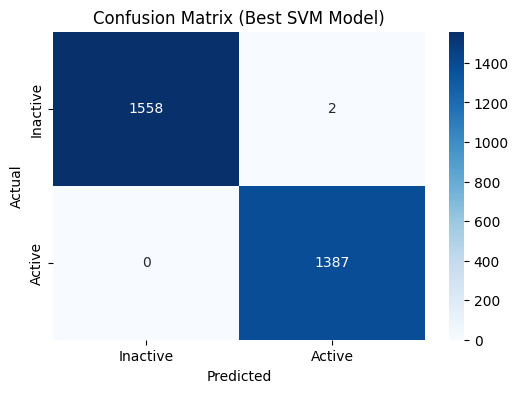

In [55]:
# confusion matrix
cm = confusion_matrix(y_test_binary, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Inactive', 'Active'], yticklabels=['Inactive', 'Active'])
plt.title('Confusion Matrix (Best SVM Model)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('images/confusion_matrix_har.png')
plt.show()

In [56]:
# compare performance across kernels (extract from GridSearchCV results)
results = pd.DataFrame(grid_search.cv_results_)
kernel_performance = results.groupby('param_svc__kernel')['mean_test_score'].max()
print("\nBest Cross-Validation Accuracy by Kernel:")
print(kernel_performance)


Best Cross-Validation Accuracy by Kernel:
param_svc__kernel
linear    0.998912
poly      0.999320
rbf       0.999320
Name: mean_test_score, dtype: float64


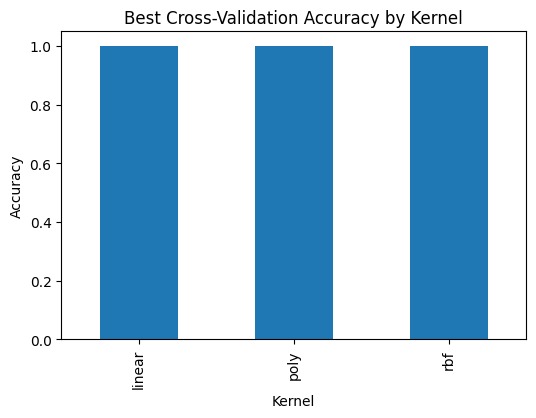

In [57]:
# visualise kernel performance
plt.figure(figsize=(6, 4))
kernel_performance.plot(kind='bar')
plt.title('Best Cross-Validation Accuracy by Kernel')
plt.xlabel('Kernel')
plt.ylabel('Accuracy')
plt.savefig('images/kernel_performance_har.png')
plt.show()

In [58]:
# --- Multi-Class SVM for 6 Activity Types ---
# use original 6-class labels
y_train_multi = y_train["Activity"]
y_test_multi = y_test["Activity"]

In [59]:
# check class distribution for multi-class
print("Multi-Class Distribution in Training Set:")
print(y_train_multi.value_counts(normalize=True))
print("Multi-Class Distribution in Test Set:")
print(y_test_multi.value_counts(normalize=True))

Multi-Class Distribution in Training Set:
Activity
LAYING                0.191376
STANDING              0.186888
SITTING               0.174918
WALKING               0.166757
WALKING_UPSTAIRS      0.145947
WALKING_DOWNSTAIRS    0.134113
Name: proportion, dtype: float64
Multi-Class Distribution in Test Set:
Activity
LAYING                0.182219
STANDING              0.180523
WALKING               0.168307
SITTING               0.166610
WALKING_UPSTAIRS      0.159824
WALKING_DOWNSTAIRS    0.142518
Name: proportion, dtype: float64


In [61]:
# create pipeline for multi-class SVM
pipeline_multi = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=50)),  # same as binary task
    ('svc', SVC())  # no class_weight='balanced' as it's a multi-class problem
])

In [62]:
# define parameter grid for GridSearchCV
param_grid_multi = [
    {'svc__kernel': ['linear'], 'svc__C': [0.1, 1, 10, 100]},
    {'svc__kernel': ['poly'], 'svc__C': [0.1, 1], 'svc__degree': [2, 3], 'svc__gamma': [0.001, 0.01, 0.1]},
    {'svc__kernel': ['rbf'], 'svc__C': [0.1, 1, 10], 'svc__gamma': [0.001, 0.01, 0.1]}
]

In [63]:
# perform GridSearchCV for multi-class
grid_search_multi = GridSearchCV(
    estimator=pipeline_multi,
    param_grid=param_grid_multi,
    scoring='accuracy',
    cv=3,
    n_jobs=-1,
    verbose=1
)
grid_search_multi.fit(X_train, y_train_multi)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=50)),
                                       ('svc', SVC())]),
             n_jobs=-1,
             param_grid=[{'svc__C': [0.1, 1, 10, 100],
                          'svc__kernel': ['linear']},
                         {'svc__C': [0.1, 1], 'svc__degree': [2, 3],
                          'svc__gamma': [0.001, 0.01, 0.1],
                          'svc__kernel': ['poly']},
                         {'svc__C': [0.1, 1, 10],
                          'svc__gamma': [0.001, 0.01, 0.1],
                          'svc__kernel': ['rbf']}],
             scoring='accuracy', verbose=1)

In [64]:
# best model and parameters
print("Best Parameters (Multi-Class):", grid_search_multi.best_params_)
print("Best Cross-Validation Accuracy (Multi-Class):", grid_search_multi.best_score_)

Best Parameters (Multi-Class): {'svc__C': 10, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}
Best Cross-Validation Accuracy (Multi-Class): 0.9003015845260993


In [65]:
# predict on test set with the best model
y_pred_multi = grid_search_multi.predict(X_test)

In [66]:
# classification report for multi-class
print("\nClassification Report on Test Set (Multi-Class):")
print(classification_report(y_test_multi, y_pred_multi))


Classification Report on Test Set (Multi-Class):
                    precision    recall  f1-score   support

            LAYING       1.00      0.98      0.99       537
           SITTING       0.87      0.87      0.87       491
          STANDING       0.88      0.90      0.89       532
           WALKING       0.90      0.95      0.93       496
WALKING_DOWNSTAIRS       0.96      0.86      0.91       420
  WALKING_UPSTAIRS       0.87      0.90      0.88       471

          accuracy                           0.91      2947
         macro avg       0.91      0.91      0.91      2947
      weighted avg       0.91      0.91      0.91      2947



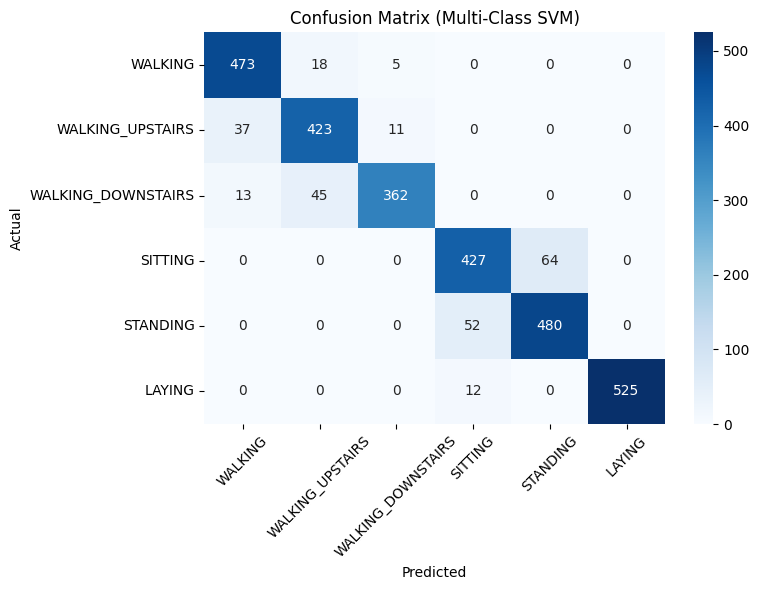

In [67]:
# confusion matrix for multi-class
cm_multi = confusion_matrix(y_test_multi, y_pred_multi, labels=list(activity_map.values()))
plt.figure(figsize=(8, 6))
sns.heatmap(cm_multi, annot=True, fmt='d', cmap='Blues', xticklabels=list(activity_map.values()), yticklabels=list(activity_map.values()))
plt.title('Confusion Matrix (Multi-Class SVM)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('images/confusion_matrix_har_multi.png')
plt.show()

In [68]:
# compare performance across kernels for multi-class
results_multi = pd.DataFrame(grid_search_multi.cv_results_)
kernel_performance_multi = results_multi.groupby('param_svc__kernel')['mean_test_score'].max()
print("\nBest Cross-Validation Accuracy by Kernel (Multi-Class):")
print(kernel_performance_multi)


Best Cross-Validation Accuracy by Kernel (Multi-Class):
param_svc__kernel
linear    0.895948
poly      0.894587
rbf       0.900302
Name: mean_test_score, dtype: float64


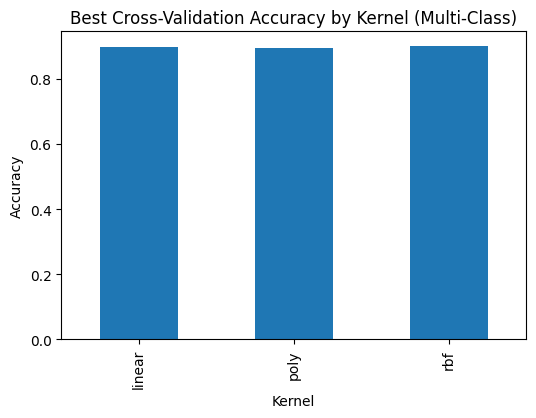

In [69]:
# visualise kernel performance for multi-class
plt.figure(figsize=(6, 4))
kernel_performance_multi.plot(kind='bar')
plt.title('Best Cross-Validation Accuracy by Kernel (Multi-Class)')
plt.xlabel('Kernel')
plt.ylabel('Accuracy')
plt.savefig('images/kernel_performance_har_multi.png')
plt.show()

In [70]:
# compare binary vs. multi-class accuracy
print("\nComparison of Test Accuracy:")
print(f"Binary Classification (Best Model): {accuracy_score(y_test_binary, y_pred):.4f}")
print(f"Multi-Class Classification (Best Model): {accuracy_score(y_test_multi, y_pred_multi):.4f}")


Comparison of Test Accuracy:
Binary Classification (Best Model): 0.9993
Multi-Class Classification (Best Model): 0.9128
